# Calculate Theil-Sen Trend (Mann Kendall Significance) for Annual Time Series for Observational Product and CORDEX Simulations

In [10]:
# Import modules
%matplotlib inline
%run /g/data/w40/ri9247/code/aus_precip_benchmarking/master_functions_bmf.ipynb
import pymannkendall as mk
from scipy import stats
import fnmatch
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec

Citation for using mann kendall trend:
    Hussain et al., (2019). pyMannKendall: a python package for non parametric Mann Kendall family of trend tests. Journal of Open Source Software, 4(39), 1556, https://doi.org/10.21105/joss.01556

## Define Spatiotemporal Boundaries

In [5]:
# Define region of interest (lat and lon boundaries for all of Australia)
lat_slice = slice(-44.5,-10)
lon_slice = slice(112,156.25)
time_slice = slice("1976-01-01", "2005-12-30")

# Define temporal scale for SPI variable (1 for 3-months, 2 for 6-months, 3 for 12-months); use "None" if not using the SPI variable
iscale = None

# Define season as a list of month numbers. If not wanting a seasonal breakdown, use None.
# Suggestions: Wet 6-month: [10,11,12,1,2,3]; Dry 6-month: [4,5,6,7,8,9]; Wet 3-month: [12,1,2]; Dry 3-month: [6,7,8]
season = None 
season_name = 'Annual'

# Path to mask datasets
mask_ds = xr.open_dataset('/g/data/w40/ri9247/CORDEX-Australasia/data/obs/AUS-44i_grid/no_indices/mask/AUS-44i_combined_quality_mask_no_oceans.nc')

# Extract combined quality mask over Australia
mask = mask_ds.station_mask.sel(lat=lat_slice, lon=lon_slice)

## Define Keywords for Data and Data Paths

### Climpact Data

In [6]:
# Define keywords to be used with f-strings to build the path to datasets
model_type = 'rcm'
grid_type = 'AUS-44i_grid'
time_period = 'historical'
variable = 'prcptot'
temporal_resolution = 'yr'
obs_temporal_resolution = 'ANN'

# Define paths to data
master_path = '/g/data/w40/ri9247/CORDEX-Australasia/data/'

model_data_path = master_path + f"{model_type}/{grid_type}/climpact/{time_period}/{variable}/{temporal_resolution}/"
agcd_data_path = master_path + f"obs/{grid_type}/climpact/{variable}/{variable}_{obs_temporal_resolution}_agcd_historical_v1_1950-2020.nc"

## Get Data File Paths

### Models

In [7]:
model_paths = get_model_files(model_data_path)

# Check that we're grabbing the correct files
pd.set_option('display.max_colwidth', None)
model_paths

,rcm,driving_gcm,dataset_path
0,CCAM-2008,NorESM1-M,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_NCC-NorESM1-M_historical_r1i1p1_CSIRO-CCAM-2008_v1_day_19600101-20051231.nc
1,CCAM-1704,MIROC5,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_MIROC-MIROC5_historical_r1i1p1_CSIRO-CCAM-1704_v1_day_19600101-20051231.nc
2,CCAM-2008,GFDL-ESM2M,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_NOAA-GFDL-GFDL-ESM2M_historical_r1i1p1_CSIRO-CCAM-2008_v1_day_19600101-20051231.nc
3,CCAM-2008,CanESM2,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_CCCma-CanESM2_historical_r1i1p1_CSIRO-CCAM-2008_v1_day_19600101-20051231.nc
4,CCAM-1704,NorESM1-M,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_NCC-NorESM1-M_historical_r1i1p1_CSIRO-CCAM-1704_v1_day_19600101-20051231.nc
5,RegCM4-7,HadGEM2-ES,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_MOHC-HadGEM2-ES_historical_r1i1p1_ICTP-RegCM4-7_v0_day_19700101-20051230.nc
6,REMO2015,NorESM1-M,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_NCC-NorESM1-M_historical_r1i1p1_GERICS-REMO2015_v1_day_19700101-20051231.nc
7,WRF360J,CanESM2,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_CCCma-CanESM2_historical_r1i1p1_UNSW-WRF360J_v1_day_19510101-20051231.nc
8,WRF360K,CanESM2,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_CCCma-CanESM2_historical_r1i1p1_UNSW-WRF360K_v1_day_19510101-20051231.nc
9,CCAM-1704,GFDL-ESM2M,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_NOAA-GFDL-GFDL-ESM2M_historical_r1i1p1_CSIRO-CCAM-1704_v1_day_19600101-20051231.nc


## Get Weighted Spatial Average at each Year for the time series and
## Calculate Mann-Kendall Metrics based on time series data

### Obs - AGCD

In [21]:
data_type = 'obs'
obs_ts = get_annual_average(agcd_data_path, variable, time_slice, lat_slice, lon_slice, data_type, iscale, mask)
obs_ts_mk = mk.original_test(obs_ts)

### Models

In [11]:
# Define a data_type (daily and monthly model data need to be converted to proper units)
data_type = 'model_climpact'

# Intialize empty dictionaries to store model timeseries and Mann Kendall metrics 
model_ann_ts_dict = {}
model_ts_mk_dict = {}

# Initialize dataframe to store theil-sen trend value for sorting plots
model_ts_master_df = pd.DataFrame(columns=["theil-sen-slope", "dataset_name"])

# Loop through RCM simulations; store in a dictionary
for i, row in model_paths.iterrows():
    
    # Get weighted spatial annual average for time series
    model_ts = get_annual_average(row[2], variable, time_slice, lat_slice, lon_slice, data_type, iscale, mask)
    
    # Calculate Mann Kendall Metrics based on time series
    model_mk_ts = mk.original_test(model_ts)
    
    # Get slope value
    ts_slope = model_mk_ts[7]
    
    # Create a dataframe to store the slope value and corresponding dataset
    model_ts_df = pd.DataFrame({'theil-sen-slope': ts_slope, 'dataset_name': f'{row[1]}   {row[0]}'}, index=[0])   
    
    # Append slope dataframe to the master dataframe 
    model_ts_master_df = pd.concat([model_ts_master_df, model_ts_df])
    
    # Add to dictionaries
    model_ann_ts_dict[f'{row[1]}   {row[0]}'] = model_ts
    model_ts_mk_dict[f'{row[1]}   {row[0]}'] = model_mk_ts
    
# Sort dataframe from largest to smallest for plotting later    
model_ts_master_df = model_ts_master_df.sort_values("theil-sen-slope", ascending=False)
print(model_ts_mk_dict.keys())

dict_keys(['NorESM1-M   CCAM-2008', 'MIROC5   CCAM-1704', 'GFDL-ESM2M   CCAM-2008', 'CanESM2   CCAM-2008', 'NorESM1-M   CCAM-1704', 'HadGEM2-ES   RegCM4-7', 'NorESM1-M   REMO2015', 'CanESM2   WRF360J', 'CanESM2   WRF360K', 'GFDL-ESM2M   CCAM-1704', 'MIROC5   CCAM-2008', 'ACCESS1-0   WRF360K', 'MPI-ESM-LR   CCLM5-0-15', 'CNRM-CM5   CCAM-1704', 'NorESM1-M   CCLM5-0-15', 'HadGEM2-CC   CCAM-1704', 'NorESM1-M   RegCM4-7', 'HadGEM2-ES   CCLM5-0-15', 'MPI-ESM-LR   REMO2015', 'HadGEM2-ES   REMO2015', 'MPI-ESM-MR   RegCM4-7', 'ACCESS1-0   WRF360J', 'ACCESS1-0   CCAM-2008', 'ACCESS1-0   CCAM-1704'])


## Calculate Weighted Spatial Average for Sorting the Plots

In [22]:
# Intialize an empty dictionary to store model climatologies as DataArrays
climatology_model_dict = {}

# Loop through RCM simulations and calculate the model bias; store in a dictionary
for i, row in model_paths.iterrows():
    climatology_xr = get_climatology(row[2], variable, time_slice, lat_slice, lon_slice, data_type, season, iscale, mask)
    climatology_model_dict[f"{row[1]}   {row[0]}"] = climatology_xr

# Option to print dictionary keys
#print(climatology_model_dict.keys())

In [23]:
# Set up empty data frame to store values
model_weighted_avg_master_df = pd.DataFrame(columns=["weighted_average", "dataset_name"])

# Loop through Dictionary of climatologies and calculate spatial weighted average
for model_name in climatology_model_dict.keys():
    model_weighted_avg = get_weighted_spatial_average_from_data(climatology_model_dict[model_name]).round(2)
        
    # Convert the resulting xarray to a pandas df
    model_weighted_avg_df = pd.DataFrame({'weighted_average': model_weighted_avg.item(0), 'dataset_name': f'{model_name}'}, index=[0])   
    
    # Append the master time series 
    model_weighted_avg_master_df = pd.concat([model_weighted_avg_master_df, model_weighted_avg_df])
    
model_weighted_avg_master_df = model_weighted_avg_master_df.sort_values("weighted_average", ascending=False)

# Option to print weighted spatial average values
#print(model_weighted_avg_master_df)

## Plot Time series and trend lines

In [19]:
# Define function to plot trend line color based on Mann Kendall significance
def get_trend_line_color(mk_trend):
    if mk_trend == "increasing":
        color = 'darkturquoise'
    elif mk_trend == "decreasing":
        color = 'darkgoldenrod'
    elif mk_trend == "no trend":
        color = 'blueviolet'
    return color

In [20]:
color_test = get_trend_line_color(obs_ts_mk[0])
color_test

'blueviolet'

## Plot Time Series and Trend Lines

/jobfs/91839862.gadi-pbs/ipykernel_642301/4056428111.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,200,400,600,800,1000,1200])
/jobfs/91839862.gadi-pbs/ipykernel_642301/4056428111.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,200,400,600,800,1000,1200])


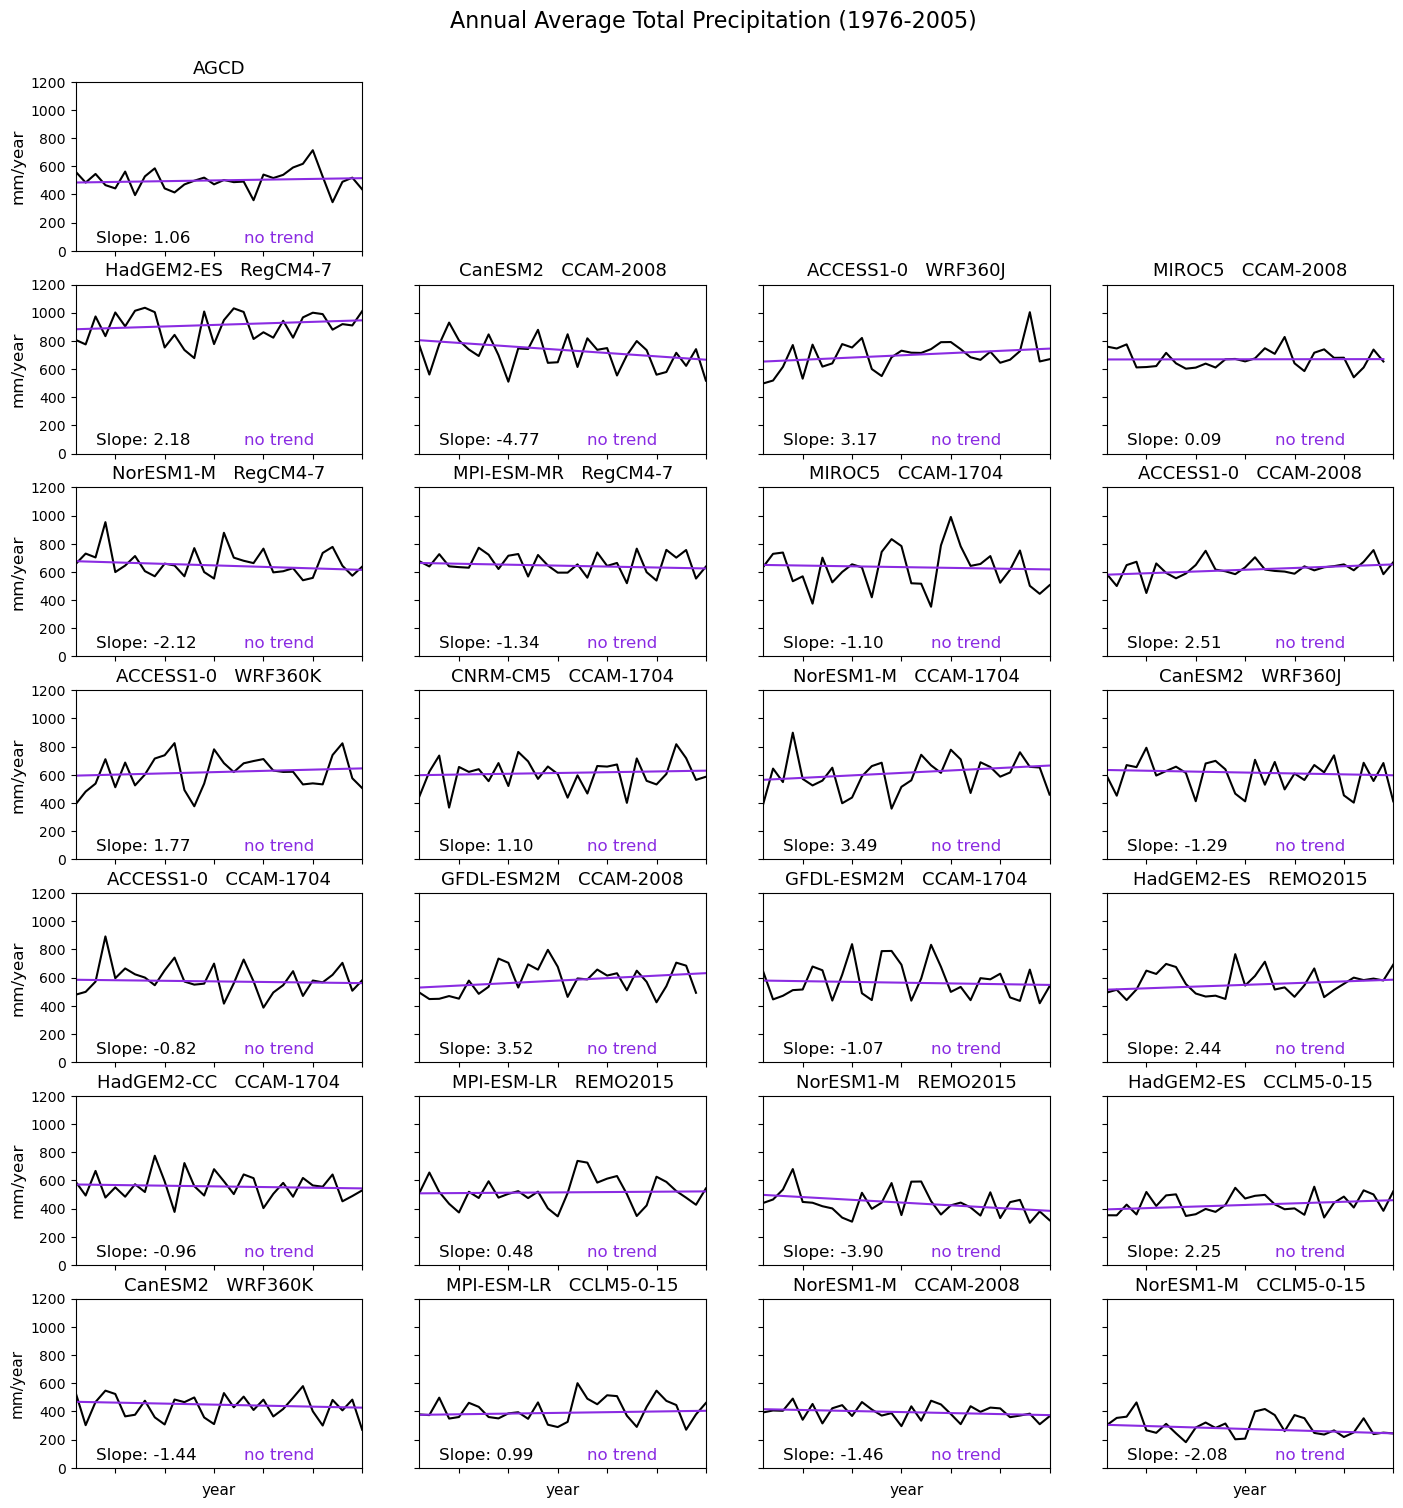

In [27]:
# Define figure size
fig = plt.figure(figsize=(17,18))
fig.suptitle("Annual Average Total Precipitation (1976-2005)", fontsize=16, y=0.92)

# Setup axes for all subplots
gs = gridspec.GridSpec(7,4,width_ratios=[1,1,1,1], height_ratios=[1,1,1,1,1,1,1])

row_max = 6
col_max = 3
row = 1
col = 0

axs = {}

# Define AGCD as only dataset on the top row
axs['AGCD'] = fig.add_subplot(gs[0,0])

# Set up Axes labels (this loops through the sorted Pandas DF to assign axes positions based on wetness)
for i, df_row_mod in model_weighted_avg_master_df.iterrows():
    axs[f'{df_row_mod[1]}'] = fig.add_subplot(gs[row,col])
    
    if col == col_max:
        row = row + 1
        col = 0 
    else:
        col = col + 1
        
# Define plots where we want to plot x and/or y axis labels
y_label = [0,1,5,9,13,17]
x_label = [22,23,24]
both_label = [21]

# Add subplot titles
for name, ax in axs.items():
    ax.set_title(name, fontsize=13)
    ax.set_xlim(1976, 2005)
    ax.set_ylim(0,1200)
    
# Set axis ticks for only left and bottom figures    
for i, ax in enumerate(fig.axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if i in y_label:
        ax.set_yticklabels([0,200,400,600,800,1000,1200])
        ax.set_ylabel("mm/year", fontsize=12)
    elif i in x_label:
        #ax.set_xticklabels([1975, 1980, 1985, 1990, 1995, 2000, 2005])
        ax.set_xlabel("year", fontsize=11)
    elif i in both_label:
        ax.set_yticklabels([0,200,400,600,800,1000,1200])
        #ax.set_xticklabels([1975, 1980, 1985, 1990, 1995, 2000, 2005])
        ax.set_xlabel("year", fontsize=11)
        ax.set_ylabel("mm/year", fontsize=11)
    else:
        continue

axs['AGCD'].plot(obs_ts.year, obs_ts, color='black', linestyle='-')
axs['AGCD'].plot(obs_ts.year, obs_ts_mk[7] * (obs_ts.year - 1976) + obs_ts_mk[8], color=get_trend_line_color(obs_ts_mk[0]), linestyle='-')
axs['AGCD'].text(1978, 60, 'Slope: %.2f' % (obs_ts_mk[7]), fontsize=12, color='black')
axs['AGCD'].text(1993, 60, f'{(obs_ts_mk[0])}', fontsize=12, color=get_trend_line_color(obs_ts_mk[0]))
    
# Models
for model_name in model_ann_ts_dict.keys():
    axs[model_name].plot(model_ann_ts_dict[model_name].year, model_ann_ts_dict[model_name], color='black', linestyle='-')
    axs[model_name].plot(model_ann_ts_dict[model_name].year, model_ts_mk_dict[model_name][7] * (model_ann_ts_dict[model_name].year - 1976) + model_ts_mk_dict[model_name][8], 
                         color=get_trend_line_color(model_ts_mk_dict[model_name][0]), linestyle='-')
    axs[model_name].text(1978, 60, 'Slope: %.2f' % (model_ts_mk_dict[model_name][7]), fontsize=12, color='black')
    axs[model_name].text(1993, 60, f'{(model_ts_mk_dict[model_name][0])}', fontsize=12, color=get_trend_line_color(model_ts_mk_dict[model_name][0]))